<a href="https://colab.research.google.com/github/Tranminhtuan48/Object-Detection-Models/blob/main/FasterRCNN_RPN_ResNet50_Backbone_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Faster R-CNN + ResNet50

## Install Prerequisites & Setup

In [ ]:
import torchvision.transforms as transforms
import cv2 as cv
import numpy as np
import torch

In [ ]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

## Predict image score, bounding boxes

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
  image = transform(image).to(device)
  image = image.unsqueeze(0)
  with torch.no_grad():
    outputs = model(image)

  pred_scores = outputs[0]['scores'].detach().cpu().numpy()
  pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

  boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
  labels = outputs[0]['labels'][:len(boxes)]
  pred_classes = [coco_names[i] for i in labels.cpu().numpy()]

  return boxes, pred_classes, labels, pred_scores


## Draw bounding box

In [ ]:
def draw_boxes(boxes, classes, labels, image):
    # Line width
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    # Font thickness
    tf = max(lw - 1, 1)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv.rectangle(
            img=image,
            pt1=(int(box[0]), int(box[1])),
            pt2=(int(box[2]), int(box[3])),
            color=color[::-1],
            thickness=lw
        )
        cv.putText(
            img=image,
            text=classes[i],
            org=(int(box[0]), int(box[1]-5)),
            fontFace=cv.FONT_HERSHEY_SIMPLEX,
            fontScale=lw / 3,
            color=color[::-1],
            thickness=tf,
            lineType=cv.LINE_AA
        )
    return image

## Load Model

Dùng 2 model là:

1. *fasterrcnn_resnet50_fpn_v2*

2. *fasterrcnn_resnet50_fpn*

In [ ]:
import torchvision

def getmodel(model_name,device):
  if model_name == 'v2':
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights = 'DEFAULT')
  else:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = 'DEFAULT')

  model = model.eval().to(device)
  return model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = getmodel('v2', device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 136MB/s]


## Output

In [ ]:
import os

path = 'data'
images = os.listdir(path)


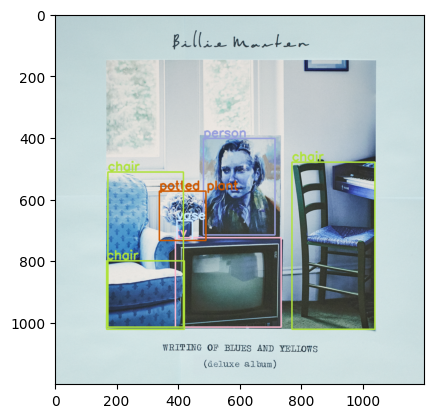

[0.9991812  0.97968996 0.96245414 0.89423704 0.8835374  0.8631978
 0.57348025 0.48159128 0.3866901  0.29913688 0.2850993  0.1812432
 0.15113565 0.14106977 0.14100465 0.07608335 0.06908856 0.06462599
 0.06062145 0.05362574 0.05037523]


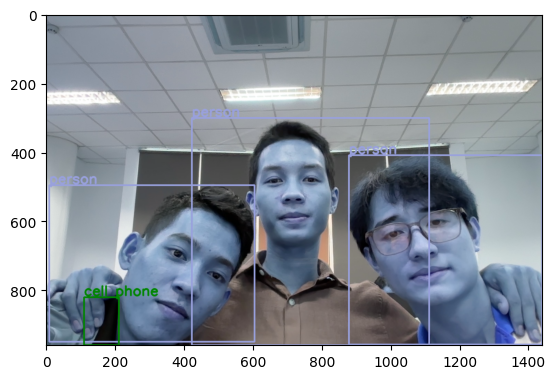

[0.9987633  0.9986339  0.9966917  0.79089314 0.34934965 0.24177623
 0.22133954 0.21749349 0.16422275 0.08549348]


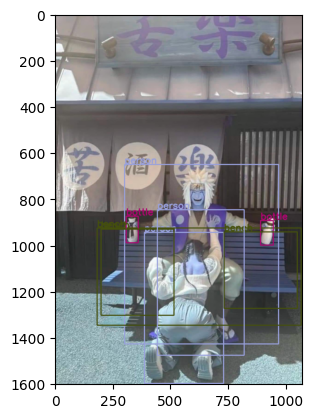

[0.99873334 0.98703337 0.97388965 0.9351665  0.82645977 0.74907875
 0.6473499  0.55400467 0.48600104 0.35701558 0.15272927 0.10996906
 0.10013837 0.08184543 0.07557541 0.06574218 0.05873778 0.05554066
 0.05149071]


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for image_name in images:
  image = Image.open('/content/data/'+image_name).convert('RGB')
  image_bgr = cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)

  with torch.no_grad():
    boxes, classes, labels, score = predict(image, model, device, 0.5)

  image = draw_boxes(boxes, classes, labels, image_bgr)
  plt.imshow(image)
  plt.show()
  print(score)